In [1]:
from urllib.parse import unquote
import numpy as np
import pandas as pd
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
links_path = Path("./data/wikispeedia_paths-and-graph/links.tsv").resolve()
assert links_path.is_file()
links = pd.read_csv(links_path, sep="\t", header=None, names=["from", "to"],skiprows=11, skip_blank_lines=True)

In [3]:
DATA_PATH = Path.cwd() / "data/wikispeedia_paths-and-graph/"
shortest_path = (DATA_PATH / "shortest-path-distance-matrix.txt").resolve()
PATHS_FINISHED = (DATA_PATH / "paths_finished.tsv").resolve()
PATHS_UNFINISHED = (DATA_PATH / "paths_unfinished.tsv").resolve()
assert shortest_path.is_file()
shortest_path = np.loadtxt(shortest_path, dtype=str)

In [4]:
def convert_to_matrix(data):
    """Replaces each row (string) with the integer values of the string and replaces _ with NaN"""
    data = np.array([[int(i) if i != "_" else np.nan for i in row] for row in data])
    return data

In [5]:
shortest_path_graph = convert_to_matrix(shortest_path)
shortest_path_graph.shape

(4604, 4604)

In [6]:
links = links.map(lambda x: unquote(x))
links.head()

,from,to
0,Áedán_mac_Gabráin,Bede
1,Áedán_mac_Gabráin,Columba
2,Áedán_mac_Gabráin,Dál_Riata
3,Áedán_mac_Gabráin,Great_Britain
4,Áedán_mac_Gabráin,Ireland


In [7]:
# create a directed graph
G = nx.DiGraph()
G.add_edges_from(links.values)
print(G)

DiGraph with 4592 nodes and 119882 edges


In [8]:
degree = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree, "degree")
links["degree"] = links["from"].map(degree)

In [9]:
# compute local clustering coefficient for each node
clustering = nx.clustering(G)
links["clustering"] = links["from"].map(clustering)

In [10]:
links["degree"].sort_values(ascending=False)

112482    1845
112531    1845
112514    1845
112515    1845
112516    1845
          ... 
104821       1
103865       1
5322         1
116823       1
52707        1
Name: degree, Length: 119882, dtype: int64

In [11]:
density = nx.density(G)
print(f"Graph density : {density}")

Graph density : 0.005686496910710776


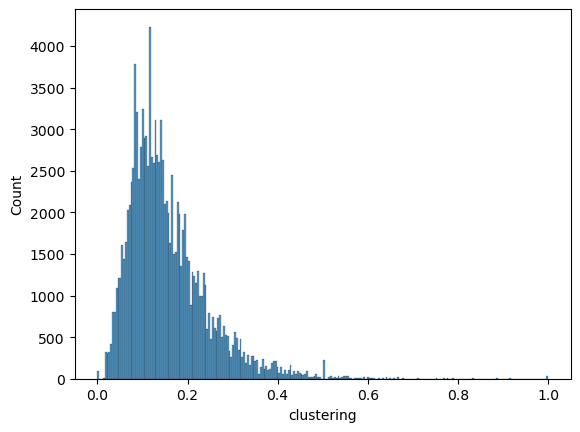

In [12]:
sns.histplot(data=links, x="clustering")
plt.show()

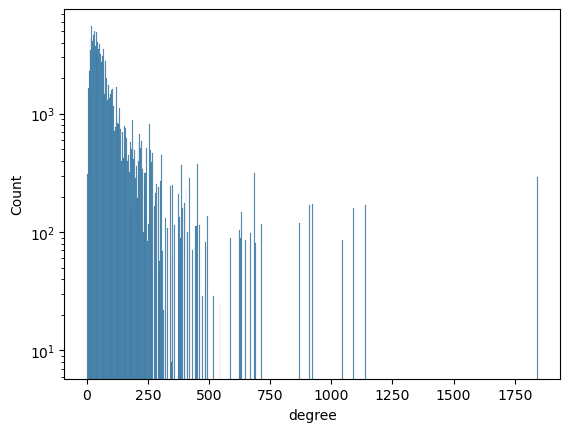

In [13]:
sns.histplot(data=links, x="degree")
plt.yscale('log')
plt.show()

In [14]:
links.sort_values(by="degree", ascending=False).drop_duplicates("degree").head(20)[["from", "degree"]]

,from,degree
112482,United_States,1845
112104,United_Kingdom,1140
37426,Europe,1092
40736,France,1044
35851,England,923
44088,Germany,912
118410,World_War_II,870
36110,English_language,716
54208,India,692
3461,Africa,689


In [15]:
# G_undirected = G.to_undirected()
# # omega = nx.algorithms.smallworld.omega(G_undirected)
# sigma = nx.algorithms.smallworld.sigma(G_undirected)
# print(
#     # omega, 
#     sigma
#     )

In [16]:
def parse_paths(dataframe):
    """Parses the path column into a list of strings"""
    dataframe["path"] = dataframe["path"].map(lambda x: x.split(";"))
    return dataframe

In [17]:
#data exploration
paths_finished = pd.read_csv(PATHS_FINISHED, sep='\t', header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'], encoding='utf-8', skiprows=16).copy(deep=True)
paths_finished["timestamp"] = pd.to_datetime(paths_finished["timestamp"], unit='s')

paths_finished = parse_paths(paths_finished)
paths_finished["path"] = paths_finished["path"].apply(lambda x: [unquote(i) for i in x])

paths_finished.head()

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,2011-02-15 03:26:49,166,"[14th_century, 15th_century, 16th_century, Pac...",NaN
1,3824310e536af032,2012-08-12 06:36:52,88,"[14th_century, Europe, Africa, Atlantic_slave_...",3.0
2,415612e93584d30e,2012-10-03 21:10:40,138,"[14th_century, Niger, Nigeria, British_Empire,...",NaN
3,64dd5cd342e3780c,2010-02-08 07:25:25,37,"[14th_century, Renaissance, Ancient_Greece, Gr...",NaN
4,015245d773376aab,2013-04-23 15:27:08,175,"[14th_century, Italy, Roman_Catholic_Church, H...",3.0


In [18]:
paths_unfinished= pd.read_csv(PATHS_UNFINISHED, sep='\t', header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'], encoding='utf-8', skiprows=17).copy(deep=True)
paths_unfinished["timestamp"] = pd.to_datetime(paths_unfinished["timestamp"], unit='s')

paths_unfinished = parse_paths(paths_unfinished)
paths_unfinished["path"] = paths_unfinished["path"].apply(lambda x: [unquote(i) for i in x])

paths_unfinished.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,2011-02-07 05:02:15,1804,[Obi-Wan_Kenobi],Microsoft,timeout
1,26141fd878806294,2011-02-07 05:14:11,1805,[Julius_Caesar],Caracas,timeout
2,2b015fb8181c48f2,2011-02-07 15:00:19,1818,"[Malawi, Democracy, Alexander_the_Great]",First_Crusade,timeout
3,53a53bc244e08a6a,2011-02-07 16:06:01,49,[Paraguay],Mount_St._Helens,restart
4,53a53bc244e08a6a,2011-02-07 17:18:25,1808,"[Paraguay, Bolivia]",Mount_St._Helens,timeout


In [19]:
# compute evolution of path degree
path_degree = pd.Series(dtype=object)
page_degree_dict = dict(zip(links["from"], links["degree"]))
for i, path in enumerate(paths_finished["path"]):
    page_degrees = []
    for page in path:
        try:
            page_degrees.append(page_degree_dict[page])
        except KeyError:
            if page == "<":
                continue
            print(f"Page {page} not found in links")
            page_degrees.append(np.nan)
    path_degree[i] = np.array(page_degrees)

Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Osteomalacia not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Doc

In [20]:
path_degree.head()

0    [102, 157, 216, 272, 375, 20, 689, 73, 31]
1                      [102, 1092, 689, 73, 31]
2        [102, 109, 173, 271, 220, 689, 73, 31]
3                          [102, 185, 228, 360]
4            [102, 635, 303, 64, 158, 220, 128]
dtype: object

In [21]:
# coompute the tendency of the path degree to first increase and then decrease
def compute_path_degree_evolution(path_degrees):
    """Computes the tendency of the path degree to first increase and then decrease.
    
    Args :
        path_degrees (np.array) : array of degrees of the pages in the path
    """
    if len(path_degrees) == 0:
        return np.nan
    return np.diff(path_degrees)

path_degree_evolutions = pd.Series(dtype=object)
path_degree_evolutions = path_degree.map(compute_path_degree_evolution)

In [22]:
path_degree_evolutions.head(10)

0    [55, 59, 56, 103, -355, 669, -616, -42]
1                     [990, -403, -616, -42]
2           [7, 64, 98, -51, 469, -616, -42]
3                              [83, 43, 132]
4             [533, -332, -239, 94, 62, -92]
5              [990, -605, 1358, -1625, -92]
6                            [484, -555, 55]
7                    [-15, 49, -7, 47, -140]
8                             [-15, 42, -93]
9                 [55, -37, -8, 7, 57, -140]
dtype: object

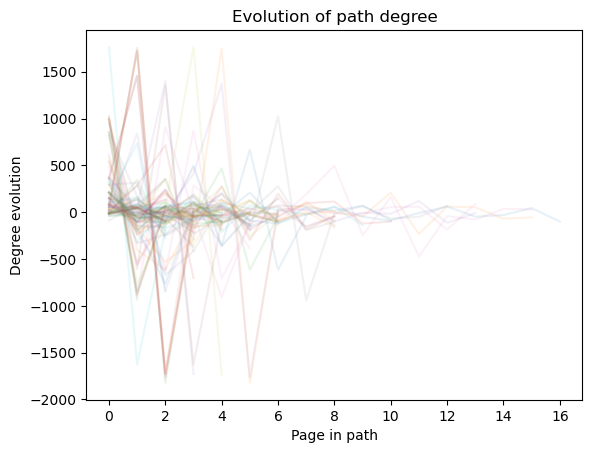

In [23]:
for path_degree_evolution in path_degree_evolutions[:100]:
    plt.plot(range(len(path_degree_evolution)), path_degree_evolution, alpha=0.1)
plt.title("Evolution of path degree")
plt.ylabel("Degree evolution")
plt.xlabel("Page in path")
plt.show()

In [24]:
def compute_slope(degree_evolution):
    """Quantifies if the degree evolution is increasing or decreasing.
    
    This is done by fitting a line to the degree evolution and returning the slope.
    """
    idx = np.isfinite(degree_evolution)
    if len(degree_evolution[idx]) < 2:
        return np.nan
    fitted_line = np.polyfit(np.arange(len(degree_evolution))[idx], degree_evolution[idx], 1)
    return fitted_line[0]

def estimate_strategy(degree_evolution, metric=np.median):
    """Uses the maximum of the degree evolution to estimate the strategy of the user.
    
    The goal is to see if the degree tends to increase before reaching the maximum and then decrease.
    """
    # print(degree_evolution)
    if np.isnan(degree_evolution).all():
        return np.nan
    max_id = np.nanargmax(degree_evolution)
    if max_id == 0:
        return np.nan
    elif max_id == len(degree_evolution) - 1:
        return np.nan
    else:
        m_before = metric(degree_evolution[:max_id])
        m_after = metric(degree_evolution[max_id:])
        if m_before is np.nan or m_after is np.nan:
            return np.nan
        return m_before, m_after

In [25]:
# compute the strategy of the user
path_strategy = pd.Series(dtype=object)
path_strategy = path_degree_evolutions.map(estimate_strategy)
path_strategy = pd.DataFrame(path_strategy.tolist(), columns=["metric_before", "metric_after"])
print(f"Len before dropna : {len(path_strategy)}")
path_strategy.dropna(inplace=True)
print(f"Len after dropna : {len(path_strategy)}")
path_strategy.head()

Len before dropna : 51318
Len after dropna : 25153


,metric_before,metric_after
0,56.0,-42.0
2,35.5,-42.0
5,192.5,-92.0
7,-15.0,20.0
8,-15.0,-25.5


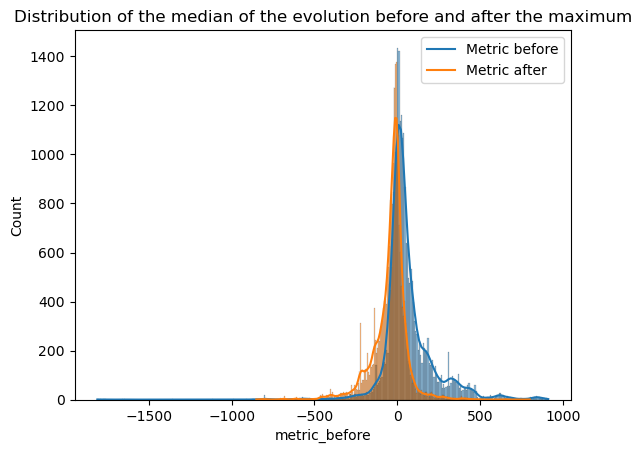

In [26]:
# plot the distribution of the metric before and after the maximum
sns.histplot(data=path_strategy, x="metric_before", kde=True)
sns.histplot(data=path_strategy, x="metric_after", kde=True)
plt.legend(["Metric before", "Metric after"])
plt.title("Distribution of the median of the evolution before and after the maximum")
plt.show()

Len before dropna : 51318
Len after dropna : 13466


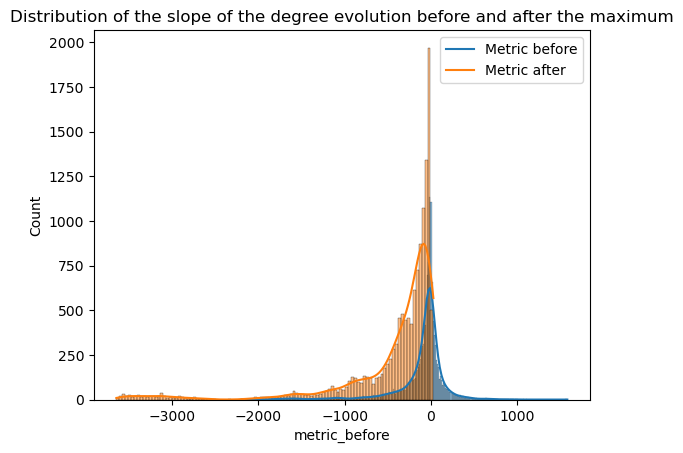

In [27]:
# compute the strategy of the user
from functools import partial
path_strategy = pd.Series(dtype=object)
path_strategy = path_degree_evolutions.map(partial(estimate_strategy, metric=compute_slope))
path_strategy = pd.DataFrame(path_strategy.tolist(), columns=["metric_before", "metric_after"])
print(f"Len before dropna : {len(path_strategy)}")
path_strategy.dropna(inplace=True)
print(f"Len after dropna : {len(path_strategy)}")
# plot the distribution of the metric before and after the maximum
sns.histplot(data=path_strategy, x="metric_before", kde=True)
sns.histplot(data=path_strategy, x="metric_after", kde=True)
plt.legend(["Metric before", "Metric after"])
plt.title("Distribution of the slope of the degree evolution before and after the maximum")
plt.show()

In [35]:
# compute the slope using the degree themselves and not the evolution
path_strategy = pd.Series(dtype=object)
path_strategy = path_degree.map(partial(estimate_strategy, metric=compute_slope))
path_strategy = pd.DataFrame(path_strategy.tolist(), columns=["metric_before", "metric_after"])
print(f"Len before dropna : {len(path_strategy)}")
path_strategy.dropna(inplace=True)
print(f"Len after dropna : {len(path_strategy)}")


Len before dropna : 51318
Len after dropna : 28677


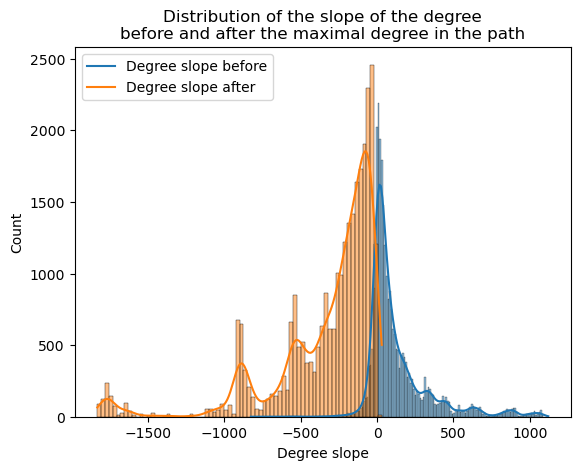

In [36]:
# plot the distribution of the metric before and after the maximum
sns.histplot(data=path_strategy, x="metric_before", kde=True)
sns.histplot(data=path_strategy, x="metric_after", kde=True)
plt.title("Distribution of the slope of the degree\nbefore and after the maximal degree in the path")
plt.legend(["Degree slope before", "Degree slope after"])
plt.xlabel("Degree slope")
plt.show()

In [30]:
# slope for the whole path
path_strategy = pd.Series(dtype=object)
path_strategy = path_degree.map(compute_slope)
path_strategy = pd.DataFrame(path_strategy.tolist(), columns=["slope"])
print(f"Len before dropna : {len(path_strategy)}")
path_strategy.dropna(inplace=True)
print(f"Len after dropna : {len(path_strategy)}")

Len before dropna : 51318
Len after dropna : 51306


<Axes: xlabel='slope', ylabel='Count'>

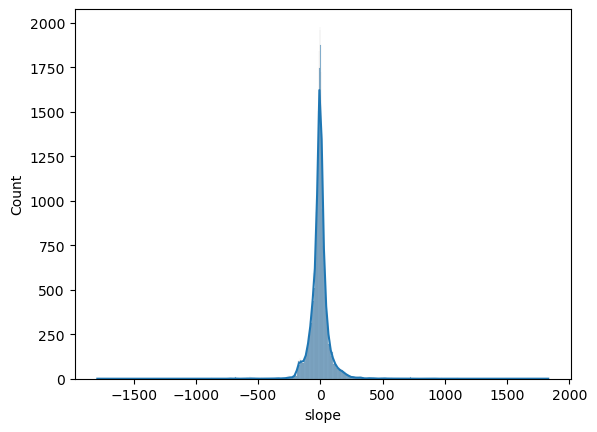

In [31]:
sns.histplot(data=path_strategy, x="slope", kde=True)

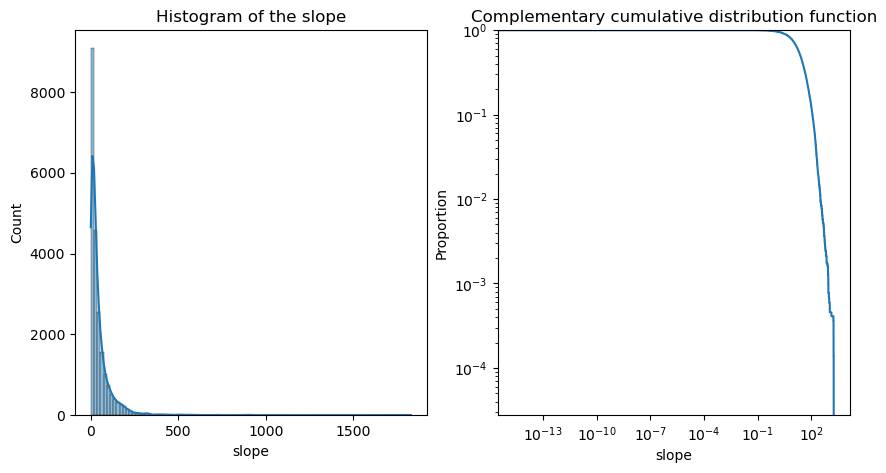

In [32]:
# check if the left half follows a power law
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
vals = path_strategy["slope"].loc[path_strategy["slope"] > 0]
sns.histplot(data=vals, kde=True, ax=axs[0], bins=100)
sns.ecdfplot(data=vals, complementary=True, ax=axs[1])
axs[0].set_title("Histogram of the slope")
axs[1].set_title("Complementary cumulative distribution function")
axs[1].set_xscale("log")
axs[1].set_yscale("log")
plt.show()

In [33]:
# check if this distribution is Gaussian
from scipy.stats import normaltest
normaltest(path_strategy["slope"], nan_policy="omit")

NormaltestResult(statistic=29366.676299883296, pvalue=0.0)